In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 参数设置
batch_size = 64 
learning_rate = 0.0002 
epochs = 50  
latent_dim = 100  
num_classes = 10  
img_shape = (1, 28, 28)  
label_smoothing = 0.9  

# 使用GPU训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载MNIST数据集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 空间注意力模块
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, in_channels, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)  # 计算通道维度的平均值
        max_out = torch.max(x, dim=1, keepdim=True)[0]  # 计算通道维度的最大值
        x = torch.cat([avg_out, max_out], dim=1)  # 将平均值和最大值拼接
        out = self.conv(x)  # 卷积操作
        return out * self.sigmoid(out)  # 返回注意力权重

In [ ]:
# 生成器模型
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)  # 标签嵌入层
        self.init_size = img_shape[1] // 4  # 初始尺寸
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2))# 条件生成，噪点维度+标签维度
        self.conv_blocks = nn.Sequential( 
            nn.BatchNorm2d(128),# 归一化
            nn.Upsample(scale_factor=2),  # 上采样,长宽扩大成两倍
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # 上采样
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, img_shape[0], 3, stride=1, padding=1),
            nn.Tanh()
        )
        self.spatial_attention = SpatialAttention(128)

    def forward(self, noise, labels):
        gen_input = torch.cat((noise, self.label_emb(labels)), -1)  # 将噪声和标签嵌入向量拼接
        out = self.l1(gen_input)  # 全连接层
        out = out.view(out.size(0), 128, self.init_size, self.init_size)  # 重塑张量
        out = self.spatial_attention(out)
        out = self.conv_blocks(out)  # 卷积块
        return out

# 判别器模型
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)  # 标签嵌入层
        self.model = nn.Sequential(
            nn.Linear(num_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)  # 将图片和标签嵌入向量拼接
        out = self.model(d_in)  # 全连接层
        return out
    

Training...
Epoch 1/50 | D Loss: 0.46164044737815857 | G Loss: 1.497086524963379


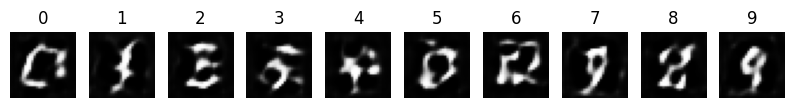

Epoch 2/50 | D Loss: 0.4344678521156311 | G Loss: 1.8439289331436157


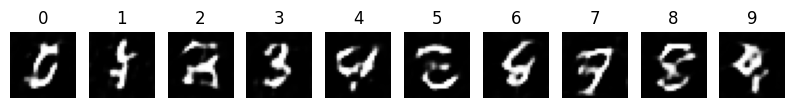

Epoch 3/50 | D Loss: 0.5809133052825928 | G Loss: 2.158536434173584


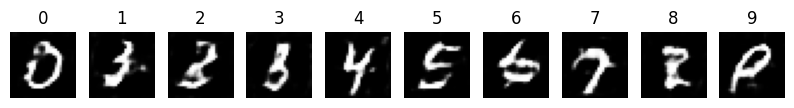

Epoch 4/50 | D Loss: 0.6246675252914429 | G Loss: 1.0513761043548584


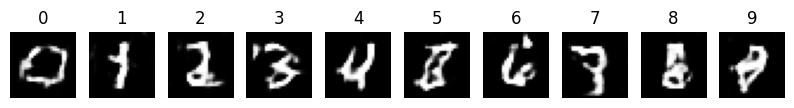

Epoch 5/50 | D Loss: 0.6084425449371338 | G Loss: 1.3103523254394531


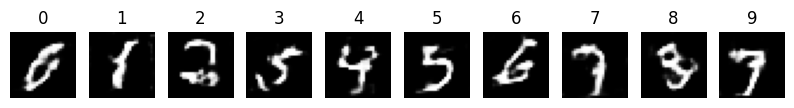

Epoch 6/50 | D Loss: 0.6084859371185303 | G Loss: 1.0313018560409546


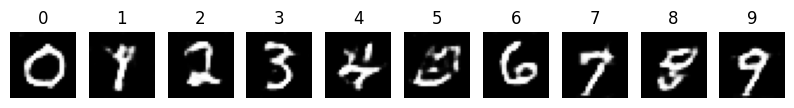

Epoch 7/50 | D Loss: 0.6050251722335815 | G Loss: 0.8988703489303589


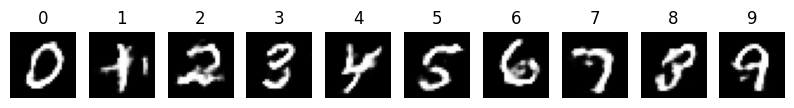

Epoch 8/50 | D Loss: 0.653114914894104 | G Loss: 1.0252145528793335


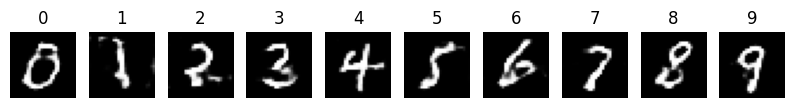

Epoch 9/50 | D Loss: 0.6688797473907471 | G Loss: 0.9027272462844849


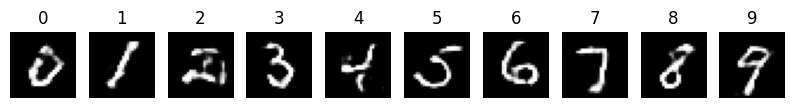

Epoch 10/50 | D Loss: 0.63669353723526 | G Loss: 0.9674796462059021


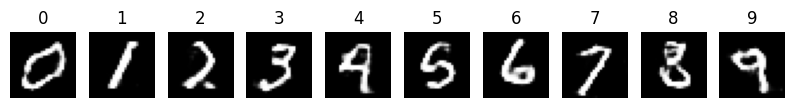

Epoch 11/50 | D Loss: 0.6346765160560608 | G Loss: 0.8984341621398926


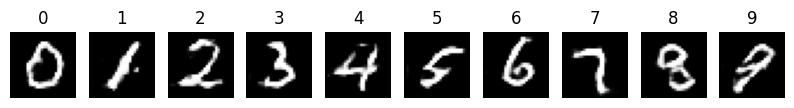

Epoch 12/50 | D Loss: 0.6414416432380676 | G Loss: 0.9345071315765381


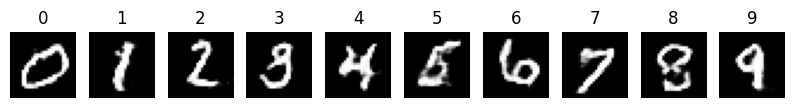

Epoch 13/50 | D Loss: 0.6843189001083374 | G Loss: 0.7748531103134155


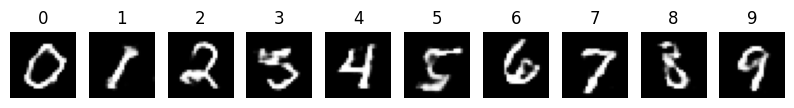

Epoch 14/50 | D Loss: 0.6466426849365234 | G Loss: 0.9110379815101624


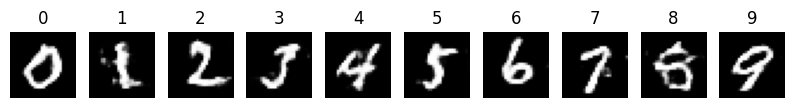

Epoch 15/50 | D Loss: 0.6818619966506958 | G Loss: 0.7768090963363647


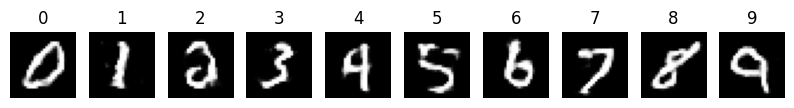

Epoch 16/50 | D Loss: 0.6718999147415161 | G Loss: 0.8755882978439331


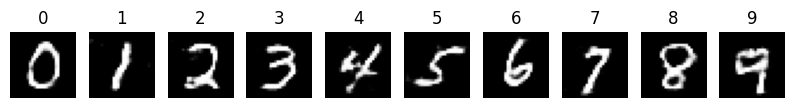

Epoch 17/50 | D Loss: 0.6965655088424683 | G Loss: 0.8558608889579773


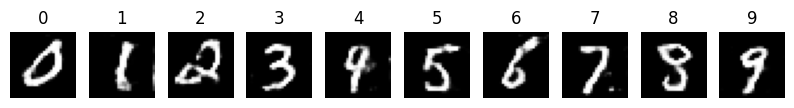

Epoch 18/50 | D Loss: 0.6756141781806946 | G Loss: 0.81943678855896


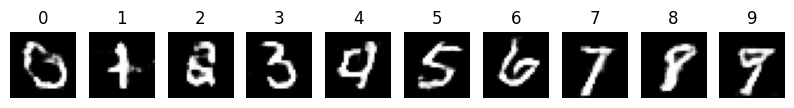

Epoch 19/50 | D Loss: 0.6555017232894897 | G Loss: 0.8475961089134216


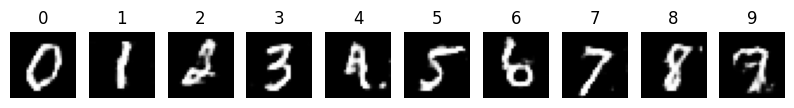

Epoch 20/50 | D Loss: 0.6327514052391052 | G Loss: 0.9078713059425354


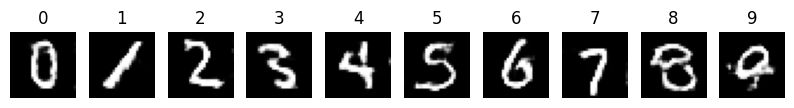

Epoch 21/50 | D Loss: 0.6734711527824402 | G Loss: 0.7373114824295044


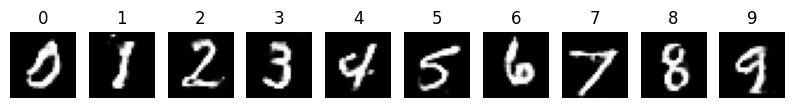

Epoch 22/50 | D Loss: 0.7036446332931519 | G Loss: 0.8413043022155762


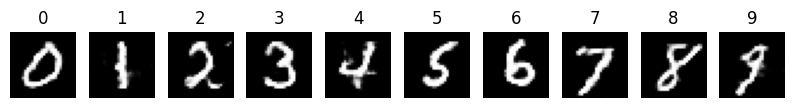

Epoch 23/50 | D Loss: 0.6885266304016113 | G Loss: 0.7124251127243042


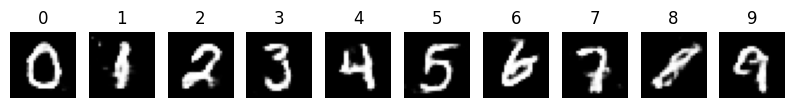

Epoch 24/50 | D Loss: 0.6502286791801453 | G Loss: 0.8745810985565186


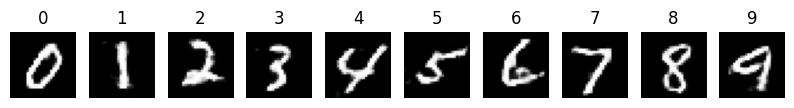

Epoch 25/50 | D Loss: 0.6660569906234741 | G Loss: 0.7836990356445312


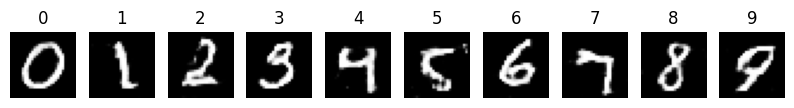

Epoch 26/50 | D Loss: 0.6784234046936035 | G Loss: 0.7904237508773804


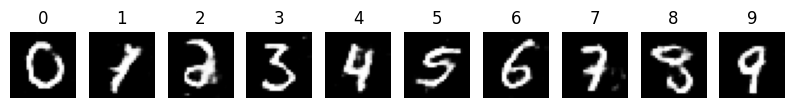

Epoch 27/50 | D Loss: 0.6808274388313293 | G Loss: 0.766116738319397


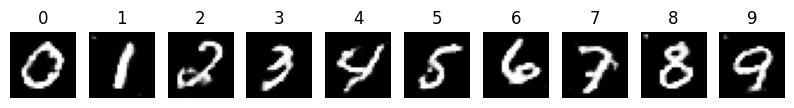

Epoch 28/50 | D Loss: 0.6856961846351624 | G Loss: 0.775556206703186


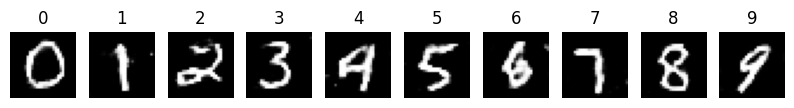

Epoch 29/50 | D Loss: 0.701615035533905 | G Loss: 0.7817578315734863


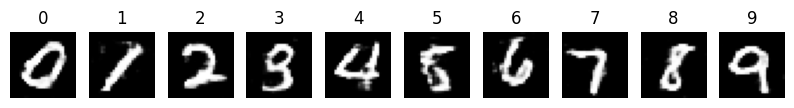

Epoch 30/50 | D Loss: 0.67514967918396 | G Loss: 0.8541512489318848


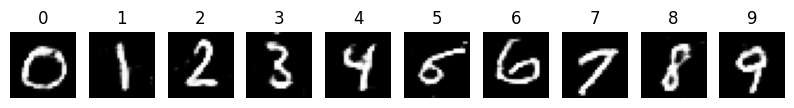

Epoch 31/50 | D Loss: 0.662025511264801 | G Loss: 0.7859998941421509


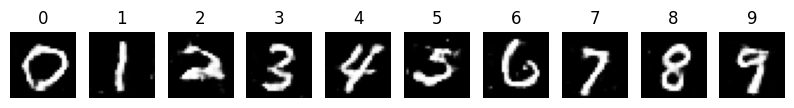

Epoch 32/50 | D Loss: 0.6898019313812256 | G Loss: 0.8806109428405762


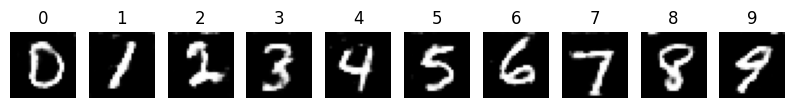

Epoch 33/50 | D Loss: 0.6545522212982178 | G Loss: 0.8628536462783813


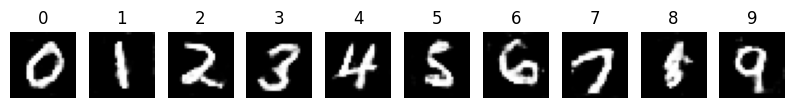

Epoch 34/50 | D Loss: 0.6631749272346497 | G Loss: 0.9526327848434448


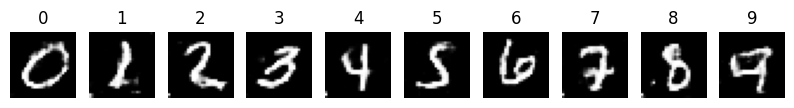

Epoch 35/50 | D Loss: 0.6654697060585022 | G Loss: 0.7995021343231201


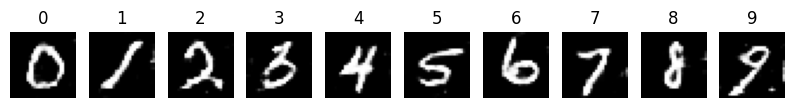

Epoch 36/50 | D Loss: 0.6677637100219727 | G Loss: 0.7653700709342957


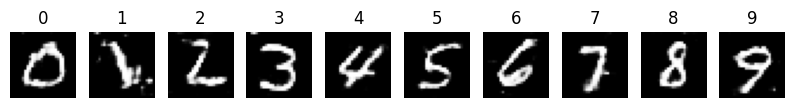

Epoch 37/50 | D Loss: 0.6897169351577759 | G Loss: 0.8329057693481445


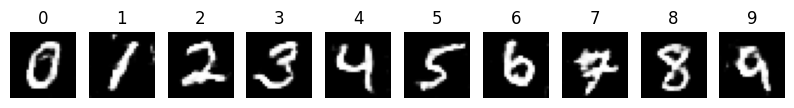

Epoch 38/50 | D Loss: 0.6614261865615845 | G Loss: 0.7841875553131104


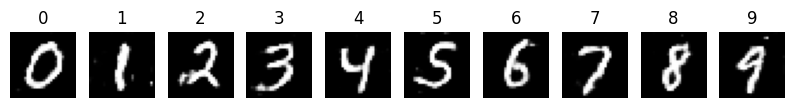

Epoch 39/50 | D Loss: 0.6583422422409058 | G Loss: 0.7844558954238892


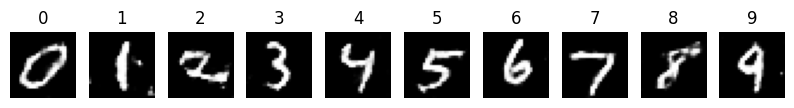

Epoch 40/50 | D Loss: 0.6344082951545715 | G Loss: 0.8104626536369324


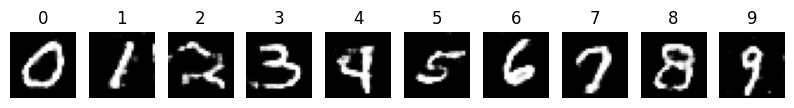

Epoch 41/50 | D Loss: 0.7016386389732361 | G Loss: 0.8526941537857056


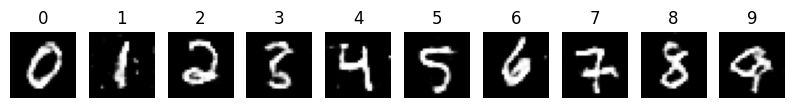

Epoch 42/50 | D Loss: 0.6907310485839844 | G Loss: 0.7966315746307373


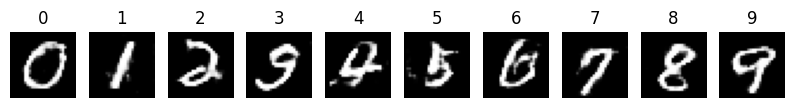

Epoch 43/50 | D Loss: 0.7064827680587769 | G Loss: 0.772511899471283


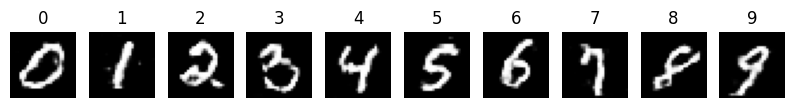

Epoch 44/50 | D Loss: 0.6857497096061707 | G Loss: 0.8901041150093079


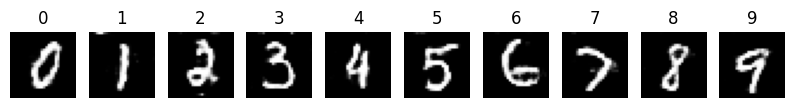

Epoch 45/50 | D Loss: 0.6817640066146851 | G Loss: 0.7529497146606445


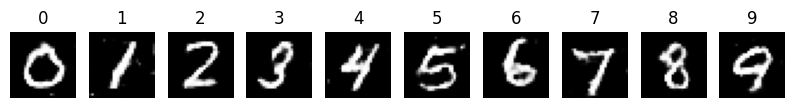

Epoch 46/50 | D Loss: 0.6823998689651489 | G Loss: 0.8062351942062378


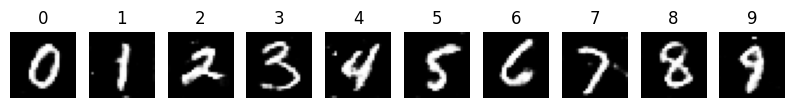

Epoch 47/50 | D Loss: 0.6946947574615479 | G Loss: 0.8024580478668213


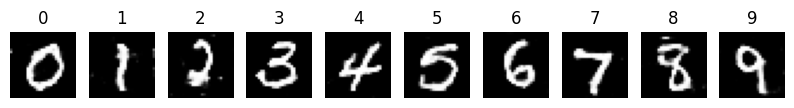

Epoch 48/50 | D Loss: 0.6306591033935547 | G Loss: 0.8508744239807129


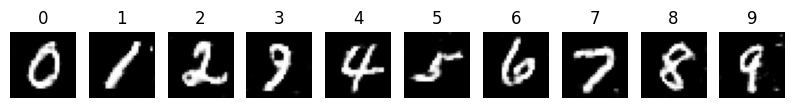

Epoch 49/50 | D Loss: 0.6944130063056946 | G Loss: 0.793197751045227


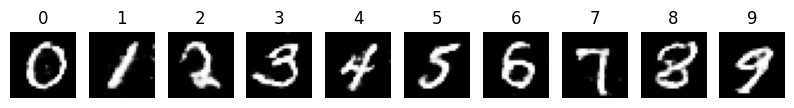

Epoch 50/50 | D Loss: 0.6761507987976074 | G Loss: 0.9466902017593384


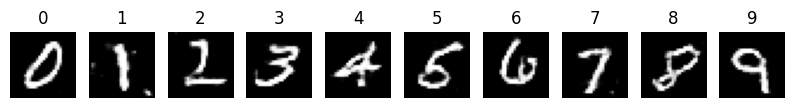

In [5]:
# 初始化模型和优化器
def train_model():
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    adversarial_loss = nn.BCELoss().to(device)  # 二分类交叉熵损失

    # 训练
    for epoch in range(epochs):
        for i, (imgs, labels) in enumerate(train_loader):
            batch_size = imgs.size(0)
            valid = torch.full((batch_size, 1), label_smoothing, device=device)  # 真实标签
            fake = torch.zeros(batch_size, 1, device=device)  # 假标签
            
            real_imgs = imgs.to(device)
            labels = labels.to(device)

            # 训练生成器
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim, device=device)  # 随机噪声
            gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)  # 随机生成标签
            gen_imgs = generator(z, gen_labels)  # 生成图片
            g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)  # 生成器损失
            g_loss.backward()
            optimizer_G.step()

            # 训练判别器
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)  # 真实图片损失
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)  # 假图片损失
            d_loss = (real_loss + fake_loss) / 2  # 判别器损失
            d_loss.backward()
            optimizer_D.step()

        print(f"Epoch {epoch + 1}/{epochs} | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

        # 生成0到9的数字图片
        def generate_digits():
            fig, axs = plt.subplots(1, num_classes, figsize=(num_classes, 1))
            for digit in range(num_classes):
                z = torch.randn(1, latent_dim, device=device)  # 随机噪声
                label = torch.tensor([digit], device=device)  # 数字标签
                gen_img = generator(z, label)  # 生成图片
                gen_img = gen_img.detach().cpu().numpy().reshape(28, 28)  # 转换为numpy数组
                axs[digit].imshow(gen_img, cmap='gray')  # 显示图片
                axs[digit].axis('off')
                axs[digit].set_title(str(digit))
            plt.show()

        generate_digits()
    return generator, discriminator

print("Training...")
generator, discriminator = train_model()


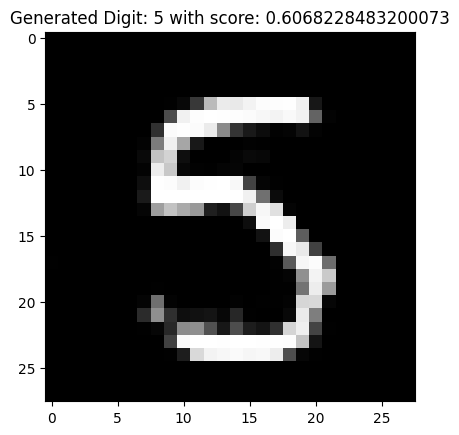

In [ ]:
def generate_digit(digit, num_attempts=100):# 从100张生成的图片中选取置信度最高的图片
    best_img = None
    best_score = float('-inf')
    for _ in range(num_attempts):
        z = torch.randn(1, latent_dim, device=device)
        label = torch.tensor([digit], device=device)
        gen_img = generator(z, label)
        score = discriminator(gen_img, label)
        if score > best_score:
            best_score = score
            best_img = gen_img.detach().cpu().numpy().reshape(28, 28)
    
    plt.imshow(best_img, cmap='gray')
    plt.title(f'Generated Digit: {digit} with score: {best_score.item()}')
    plt.show()

generate_digit(5) 